# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** An alternative to quantile regression useful for baseline model.

</font>
</div>

# Import modules
<hr style="border:2px solid black"> </hr>

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from pprint import pprint
from sklearn.base import clone
rcParams['figure.figsize'] = 16, 8
rcParams['font.size'] = 20

# Create a test function & dataset

<div class="alert alert-block alert-info">
<font color=black><br>

- To make the problem interesting, we generate observations of the target y as the sum of a deterministic term computed by the function f and a random noise term that follows a centered log-normal. 
- To make this even more interesting we consider the case where the amplitude of the noise depends on the input variable x (**heteroscedastic** noise).
- The lognormal distribution is non-symmetric and long tailed: observing large outliers is likely but it is impossible to observe small outliers.    

<br></font>
</div>

In [2]:
def f(x):
    """The function to predict."""
    return 2*x + x * np.sin(x)

rng = np.random.RandomState(42)
X = np.atleast_2d(rng.uniform(0, 10.0, size=1000)).T
expected_y = f(X).ravel()

In [3]:
sigma = 0.5 + X.ravel() / 10
noise = rng.lognormal(sigma=sigma) - np.exp(sigma ** 2 / 2)
y = expected_y + noise

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# Create an evenly spaced evaluation set of input values spanning the [0, 10] range.
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T

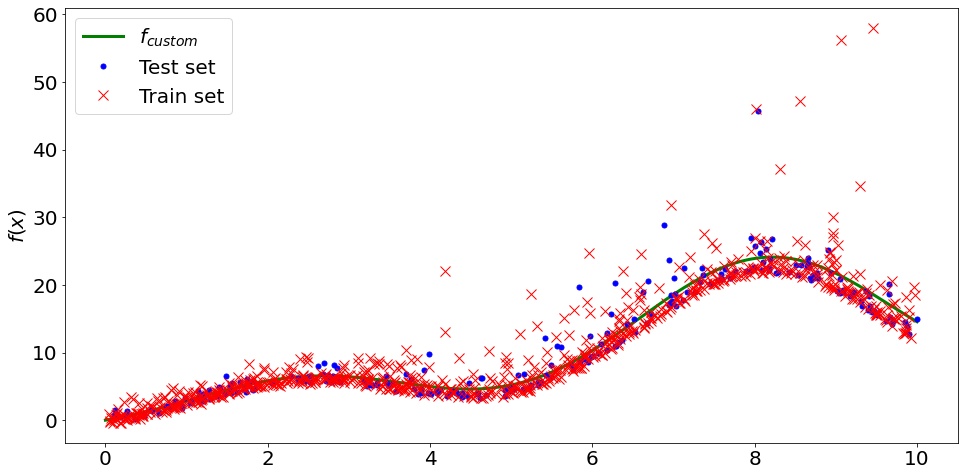

In [14]:
fig = plt.figure()
plt.plot(xx, f(xx), 'g-', lw =3, label = r'$f_{custom}$')
plt.plot(X_test, y_test, 'b.', markersize = 10, label = 'Test set')
plt.plot(X_train, y_train, 'rx', markersize = 10, lw = 1, label = 'Train set')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.show()

In [15]:
# split the data into a train set further for validation purpouses
# Yes, I know the dataset is small!
X1, X2, y1, y2 = train_test_split(X_train, y_train, test_size=0.5, shuffle = True) 

# An alternative (with assumptions)

<div class="alert alert-block alert-info">
<font color=black><br>

- Let's assume the predictions follow a normal distribution.
- This is a strong **assumption** but it seems to be good enough so it is still commonly used.
- We'll have two models: one for the the prediction and one for its error.
- So your prediction is the mean of the gaussian distribution, whereas the error estimate is its standard deviation.
- This can be implemented in two ways here referred to as option #1 & #2.
- For both options we use the table below to get the percentiles.
- **Remember that**: standard deviation is the square root of the variance. 
- **Remember that**: the variance is the mean absolute error.
    
<br></font>
</div>

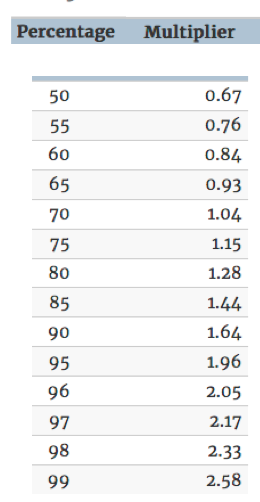

## Option #1 - Training a machine learning model to predict values, and using its RMSE to compute the error = (aka Maximum Likelihood Estimation)

<div class="alert alert-block alert-info">
<font color=black><br>

- This model assumes that the standard deviation of the normal distribution is constant. 
- Essentially, the error is constant for all the predictions.
- Keep in mind that we have split the dataset in 3 sets: training (training2 + test2=validation) and test. 
- aka Maximum Likelihood Estimation according to this Ref: https://www.godaddy.com/engineering/2020/01/10/better-prediction-interval-with-neural-network/

<br></font>
</div>

In [5]:
# base model can be any regression model
modelbase_mode = GradientBoostingRegressor()
modelbase_mode.fit(X1, y1);
base_prediction = modelbase_mode.predict(X2) 
# Compute the RMSE value
error = mean_squared_error(base_prediction, y2) ** 0.5
# compute the mean and standard deviation of the distribution 
mean = modelbase_mode.predict(X_test) 
st_dev = error

In [6]:
# This is a single (symmetric) value applied to all of the predictions!
st_dev

3.806888116082883

In [7]:
predictions = pd.DataFrame()
predictions["mean"] = mean 
predictions["X_test"] = X_test
predictions["up"] = mean + 1.96 * st_dev
predictions["low"] = mean - 1.96 * st_dev 
predictions.sort_values(by = ['X_test'], inplace = True)

In [8]:
predictions.head(5)

,mean,X_test,up,low
170,0.219193,0.109958,7.680693,-7.242308
81,0.219193,0.113536,7.680693,-7.242308
202,0.818291,0.143935,8.279792,-6.643210
233,0.367545,0.181102,7.829046,-7.093955
136,0.509657,0.253507,7.971158,-6.951843


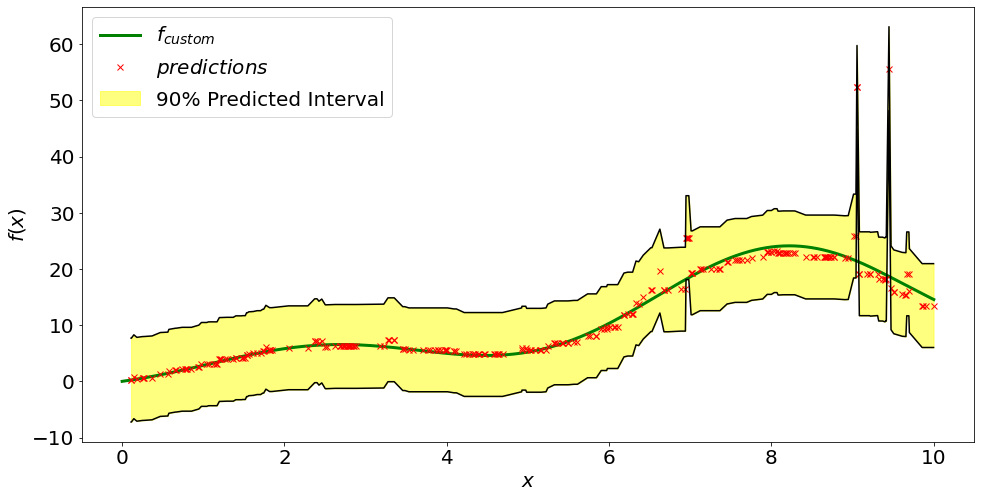

In [9]:
fig = plt.figure()

plt.plot(xx, f(xx), 'g-', lw = 3, label = r'$f_{custom}$')
plt.plot(X_test, mean, 'rx', lw =3, label = r'$predictions$')

plt.plot(predictions["X_test"], predictions["up"], 'k-')
plt.plot(predictions["X_test"], predictions["low"], 'k-')

plt.fill_between(predictions["X_test"], predictions["low"], predictions["up"], alpha = 0.5,
                 label = '90% Predicted Interval', color = "yellow")

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend()
plt.show()

## Option #2 - Training a machine learning model to predict values and errors

<div class="alert alert-block alert-info">
<font color=black><br>

- In practice, the error is **not** always constant (it depends on the features).
- Bare in mind that we are addressing the fact it may not be constant, but what we get is **still** a symmetric estimate of the variabilty.
- Therefore, as an improvement, we can fit a model to learn the error itself.
- As before, the base model is learnt from the training data.
- Then, a second model (the error model) is trained on a validation set to predict the squared difference between the predictions and the real values.
- The standard deviation of the distribution is computed by taking the root of the error predicted by the error model.

<br></font>
</div>

In [10]:
# base_model can be any regression model, a 
# sklearn.ensemble.GradientBoostingRegressor for instance 
base_model = GradientBoostingRegressor()
error_model = GradientBoostingRegressor()
base_model.fit(X1, y1) 
base_prediction = base_model.predict(X2) 
# compute the prediction error vector on the validation set 
validation_error = (base_prediction - y2) ** 2 
error_model.fit(X2, validation_error) 
# compute the mean and standard deviation of the distribution 
mean = base_model.predict(X_test) 
st_dev = error_model.predict(X_test)**0.5

In [11]:
# So we get a value which is still symmetric but different for each prediction.
st_dev

array([ 2.18339247,  1.12551367,  2.36775089,  3.05200143,  1.12551367,
        1.54876526,  2.69935588,  1.57437649,  2.69935588,  1.13769788,
        2.18339247,  1.61548046,  1.03083253,  1.03083253,  1.57437649,
        2.17670175,  2.66705596,  1.03083253,  1.03083253,  1.12551367,
        1.03083253,  6.60189554,  1.57437649,  1.12551367,  1.03083253,
        1.57437649,  2.742769  ,  3.99524259,  1.03083253,  1.54876526,
        1.57437649,  1.61548046,  2.49219058,  1.03083253, 32.766286  ,
        1.57437649,  1.12551367,  2.50707415,  1.61548046,  2.52244055,
        1.61548046,  2.17670175,  1.57437649,  1.03083253,  1.57437649,
        1.34893623,  1.34893623,  1.14760431,  1.57437649,  1.03083253,
        1.61548046,  2.76124008,  1.03083253,  2.36775089,  9.57181672,
        1.57437649,  2.49219058,  2.59908916,  1.57437649,  1.14760431,
        1.34893623,  1.34893623,  1.57437649,  1.03083253,  3.3609751 ,
        2.2619307 ,  2.49219058,  4.83724148,  4.52374883,  1.03

In [12]:
predictions = pd.DataFrame()
predictions["mean"] = mean 
predictions["X_test"] = X_test
predictions["up"] = mean + 1.96 * st_dev
predictions["low"] = mean - 1.96 * st_dev 
predictions.sort_values(by = ['X_test'], inplace = True)

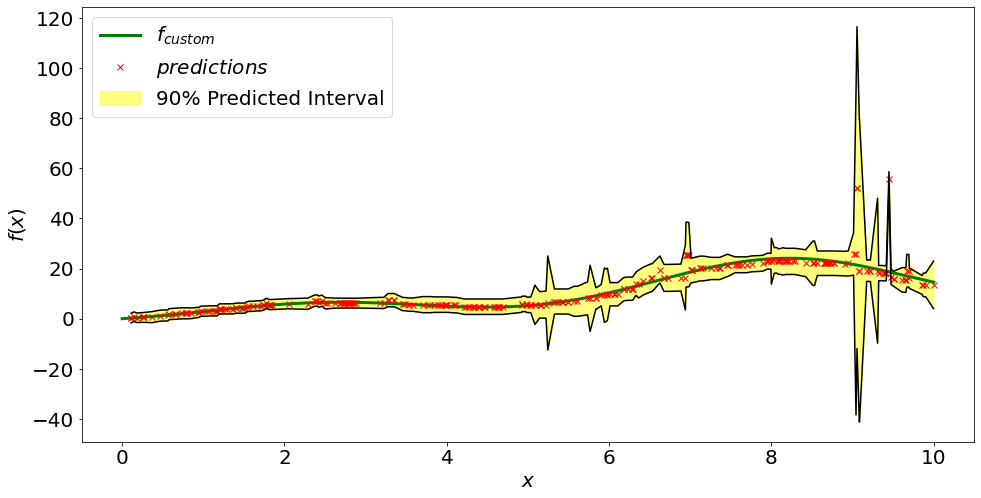

In [13]:
fig = plt.figure()

plt.plot(xx, f(xx), 'g-', lw = 3, label = r'$f_{custom}$')
plt.plot(X_test, mean, 'rx', lw =3, label = r'$predictions$')

plt.plot(predictions["X_test"], predictions["up"], 'k-')
plt.plot(predictions["X_test"], predictions["low"], 'k-')

plt.fill_between(predictions["X_test"], predictions["low"], predictions["up"], alpha = 0.5,
                 label = '90% Predicted Interval', color = "yellow")

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend()
plt.show()

# References

<div class="alert alert-warning">
<font color=black>

- https://medium.com/@qucit/a-simple-technique-to-estimate-prediction-intervals-for-any-regression-model-2dd73f630bcb<br>

</font>
</div>

# Conclusion
<hr style="border:2px solid black"> </hr>

<div class="alert alert-danger">
<font color=black>

- The second method seemd to be **more premising** than first.
- We are **not** address the asymmetric nature of the prediction error.
- Compared to the **quantile** loss function we are fitting only two models (option #2): prediction and error estimators.
- When you want a different quantile we just use the table reported above.                                                                             
- Qunatile regressor or not, you still have to tune the models. 
- At the of the day, you'll end up with the same amount of work to do.
                                                                             
</font>
</div>